In [1]:
from dataclasses import dataclass
import numpy as np
import matplotlib.pyplot as plt
from mcc import Contract, ResolvableContract, EuropeanOption, Zero, One, Give, Scale, And, Or, Until, KonstFloat, Stock, GeometricBrownianMotion, Model, simulate_equity_black_scholes_model

In [2]:
@dataclass
class EquityCall(ResolvableContract):
    maturity: np.datetime64
    stock: str
    strike: float
    currency: str
    
    def resolve(self) -> Contract:
        fw = And(Scale(Stock(self.stock), One(self.currency)), Give(Scale(KonstFloat(self.strike), One(self.currency))))
        return EuropeanOption(self.maturity, fw)

In [3]:
maturity = np.datetime64("2021-06-01")
stock = "ABC"
strike = 55
currency = "USD"

In [4]:
call = EquityCall(maturity, stock, strike, currency)
call.resolve()

EuropeanOption(maturity=numpy.datetime64('2021-06-01'), contract=And(contract1=Scale(observable=Stock(identifier='ABC'), contract=One(currency='USD')), contract2=Give(contract=Scale(observable=KonstFloat(constant=55), contract=One(currency='USD')))))

In [5]:
call.resolve().resolve()

When(observable=At(date=numpy.datetime64('2021-06-01')), contract=Or(contract1=And(contract1=Scale(observable=Stock(identifier='ABC'), contract=One(currency='USD')), contract2=Give(contract=Scale(observable=KonstFloat(constant=55), contract=One(currency='USD')))), contract2=Zero()))

In [6]:
spot = 50
volatility = 0.2
dategrid = np.array([
    np.datetime64("2021-01-01"),
    np.datetime64("2021-02-01"),
    np.datetime64("2021-03-01"),
    np.datetime64("2021-04-01"),
    np.datetime64("2021-05-01"),
    np.datetime64("2021-06-01")])
n = 100
rnd = np.random.RandomState(123)

(100, 6)

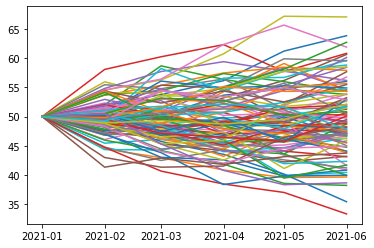

In [7]:
model = simulate_equity_black_scholes_model("ABC", "USD", spot, dategrid, volatility, 0, n, rnd)
plt.plot(model.dategrid, model.simulated_stocks["ABC"].T)
model.simulated_stocks["ABC"].shape

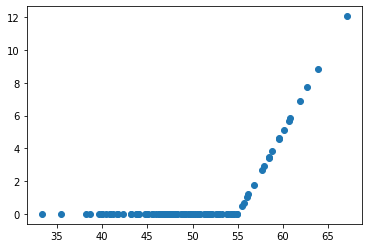

In [8]:
cf = model.generate_simple_cashflows_in_numeraire_currency(call)
plt.scatter(model.simulated_stocks["ABC"][:,-1], cf.cashflows);

In [9]:
@dataclass
class EquityPut(ResolvableContract):
    maturity: np.datetime64
    stock: str
    strike: float
    currency: str
    
    def resolve(self) -> Contract:
        fw = And(Scale(KonstFloat(self.strike), One(self.currency)), Give(Scale(Stock(self.stock), One(self.currency))))
        return EuropeanOption(self.maturity, fw)

In [10]:
put = EquityPut(maturity, stock, strike, currency)
call.resolve()

EuropeanOption(maturity=numpy.datetime64('2021-06-01'), contract=And(contract1=Scale(observable=Stock(identifier='ABC'), contract=One(currency='USD')), contract2=Give(contract=Scale(observable=KonstFloat(constant=55), contract=One(currency='USD')))))

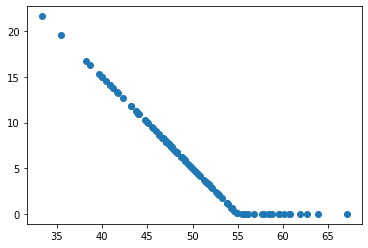

In [11]:
cf = model.generate_simple_cashflows_in_numeraire_currency(put)
plt.scatter(model.simulated_stocks["ABC"][:,-1], cf.cashflows);

In [12]:
synthetic_forward = And(call, Give(put))
synthetic_forward

And(contract1=EquityCall(maturity=numpy.datetime64('2021-06-01'), stock='ABC', strike=55, currency='USD'), contract2=Give(contract=EquityPut(maturity=numpy.datetime64('2021-06-01'), stock='ABC', strike=55, currency='USD')))

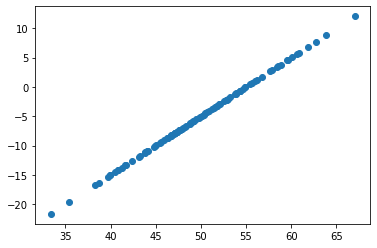

In [13]:
cf = model.generate_simple_cashflows_in_numeraire_currency(synthetic_forward)
plt.scatter(model.simulated_stocks["ABC"][:,-1], cf.cashflows);

In [14]:
upper_knockout = Until(Stock("ABC") >= 63, call)
upper_knockout

Until(observable=GreaterOrEqualThan(observable1=Stock(identifier='ABC'), observable2=KonstFloat(constant=63)), contract=EquityCall(maturity=numpy.datetime64('2021-06-01'), stock='ABC', strike=55, currency='USD'))

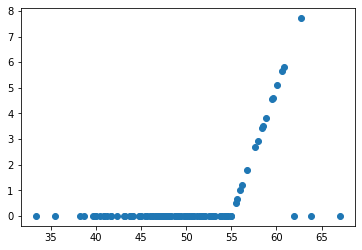

In [15]:
cf = model.generate_simple_cashflows_in_numeraire_currency(upper_knockout)
plt.scatter(model.simulated_stocks["ABC"][:,-1], cf.cashflows);